# Sentiment Analysis of Movie Reviews Using Support Vector Machine (SVM)

## Importing Libraries

In [6]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Toolkit for text cleaning
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re

# Scikit-learn tools for SVM and evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

print("Libraries imported successfully!")

Libraries imported successfully!


## Data Loading Function

In [11]:
# 2. Optimized Function to load .txt files
def load_data_from_directory(directory):
    reviews = []
    labels = []

    # Define labels based on folder names
    for label_type in ['pos', 'neg']:
        dir_path = os.path.join(directory, label_type)
        label_value = 1 if label_type == 'pos' else 0

        print(f"Loading {label_type} reviews from {dir_path}...")

        # Check if directory exists to avoid errors
        if not os.path.exists(dir_path):
            print(f"Warning: Directory {dir_path} not found.")
            continue

        # Efficiently read all files
        for filename in os.listdir(dir_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(dir_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        reviews.append(f.read())
                        labels.append(label_value)
                except Exception as e:
                    # Skip files that might have encoding issues
                    continue

    return pd.DataFrame({'review': reviews, 'sentiment': labels})

In [17]:
# INSTRUCTIONS: Set the root path to where your 'train' and 'test' folders are located
# If they are in the same folder as this notebook, leave as '.'
data_root = '.' # Change this to your dataset's root folder name

print("Starting Data Loading...")
train_df = load_data_from_directory(os.path.join(data_root, 'train'))
test_df = load_data_from_directory(os.path.join(data_root, 'test'))

print(f"\nTotal Training samples loaded: {len(train_df)}")
print(f"Total Testing samples loaded: {len(test_df)}")

# Preview the data
train_df.head()

Starting Data Loading...
Loading pos reviews from .\train\pos...
Loading neg reviews from .\train\neg...
Loading pos reviews from .\test\pos...
Loading neg reviews from .\test\neg...

Total Training samples loaded: 25000
Total Testing samples loaded: 25000


,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1


In [76]:
train_df['sentiment'].value_counts()

sentiment
1    12500
0    12500
Name: count, dtype: int64

C:\Users\Bhawna B Dhapudkar\AppData\Local\Temp\ipykernel_5292\3573250974.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=train_df, palette='viridis')


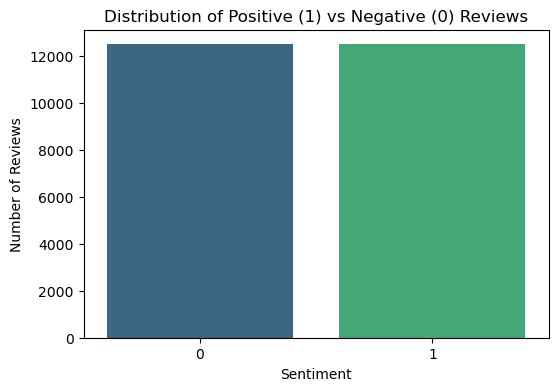

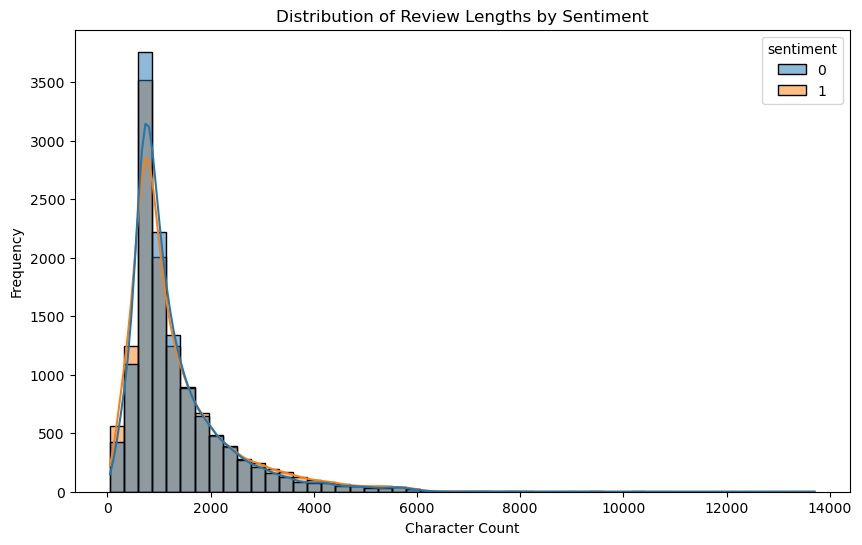

Summary Statistics for Review Lengths:
             count        mean          std   min    25%    50%     75%  \
sentiment                                                                 
0          12500.0  1302.97904   957.067769  52.0  709.0  976.5  1568.0   
1          12500.0  1347.16024  1046.747365  70.0  695.0  982.0  1651.0   

               max  
sentiment           
0           8969.0  
1          13704.0  


In [72]:
# 2.5 Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check Class Distribution (Balance)
# This ensures we have an equal number of positive and negative reviews [cite: 9]
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=train_df, palette='viridis')
plt.title('Distribution of Positive (1) vs Negative (0) Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

# 2. Analyze Review Length
# Does the length of a review correlate with sentiment?
train_df['review_length'] = train_df['review'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='review_length', hue='sentiment', kde=True, bins=50)
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.show()

# 3. Basic Statistics
print("Summary Statistics for Review Lengths:")
print(train_df.groupby('sentiment')['review_length'].describe())

## Text Preprocessing
We will clean the text by removing HTML tags, punctuation, and stopwords, followed by "Stemming" to reduce words to their root form.

In [80]:
stemmer = PorterStemmer()

def preprocess_text(text):
    # Remove HTML tags [cite: 22]
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and lowercase [cite: 22]
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()

    words = text.split()

    # CRITICAL CHANGE: Keep negation words in the dataset 
    standard_stopwords = set(stopwords.words('english'))
    negation_words = {'not', 'no', 'never', 'neither', 'nor', 'none'}
    custom_stopwords = standard_stopwords - negation_words
    
    # Stemming and Stopword removal [cite: 22]
    cleaned_words = [stemmer.stem(w) for w in words if w not in custom_stopwords]

    return " ".join(cleaned_words)

# Apply this to your dataframes again
print("Re-cleaning data with negation support...")
train_df['cleaned_review'] = train_df['review'].apply(preprocess_text)
test_df['cleaned_review'] = test_df['review'].apply(preprocess_text)
print("Preprocessing complete.")

Re-cleaning data with negation support...
Preprocessing complete.


## Feature Extraction (TF-IDF)
SVMs cannot read text directly, so we use TF-IDF (Term Frequency-Inverse Document Frequency) to convert the words into numerical vectors.

In [82]:
# We limit max_features to 5,000 to maintain high performance with SVM
print("Converting text to numerical vectors...")
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) # Using unigrams and bigrams

X_train = tfidf.fit_transform(train_df['cleaned_review'])
X_test = tfidf.transform(test_df['cleaned_review'])

y_train = train_df['sentiment']
y_test = test_df['sentiment']

print(f"Feature matrix created with shape: {X_train.shape}")

Converting text to numerical vectors...
Feature matrix created with shape: (25000, 5000)


## Model Building & Comparison (Kernels)
Per your project guide, we will train SVM models using different kernels: Linear, Polynomial, and RBF.

In [84]:
import time

kernels = ['linear', 'rbf', 'poly']
model_performance = {}

for ker in kernels:
    print(f"\nTraining SVM with {ker} kernel...")
    start_time = time.time()

    # max_iter is set to 2000 to prevent the notebook from hanging on complex kernels
    # cache_size increases memory usage to speed up training
    clf = SVC(kernel=ker, max_iter=2000, cache_size=1000)
    clf.fit(X_train, y_train)

    end_time = time.time()
    accuracy = clf.score(X_test, y_test)
    model_performance[ker] = accuracy

    print(f"Done! Kernel: {ker} | Accuracy: {accuracy:.4f} | Time: {end_time - start_time:.2f}s")


Training SVM with linear kernel...


C:\Users\Bhawna B Dhapudkar\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done! Kernel: linear | Accuracy: 0.8304 | Time: 67.59s

Training SVM with rbf kernel...


C:\Users\Bhawna B Dhapudkar\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done! Kernel: rbf | Accuracy: 0.8364 | Time: 66.53s

Training SVM with poly kernel...


C:\Users\Bhawna B Dhapudkar\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Done! Kernel: poly | Accuracy: 0.7991 | Time: 67.49s


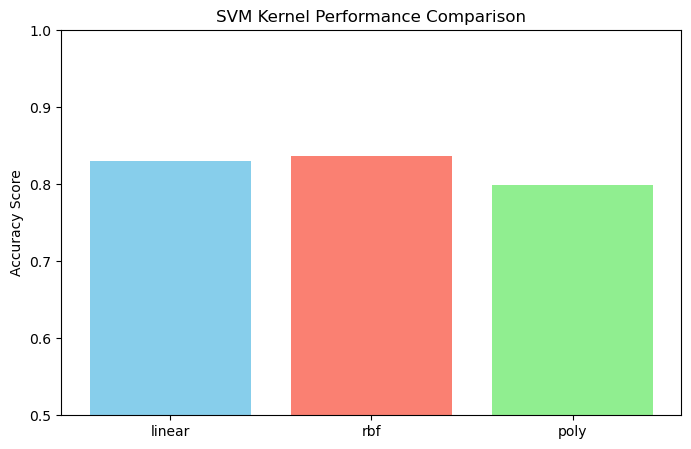

In [86]:
# Simple visualization of results
plt.figure(figsize=(8, 5))
plt.bar(model_performance.keys(), model_performance.values(), color=['skyblue', 'salmon', 'lightgreen'])
plt.title('SVM Kernel Performance Comparison')
plt.ylabel('Accuracy Score')
plt.ylim(0.5, 1.0)
plt.show()

## Final Evaluation (Metrics & Confusion Matrix)
Finally, we generate a detailed report showing Precision, Recall, and the Confusion Matrix to see exactly where the model is succeeding or failing.

Training the final model for detailed evaluation...

--- Project Performance Metrics ---
              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     12500
    Positive       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

Generating Confusion Matrix...


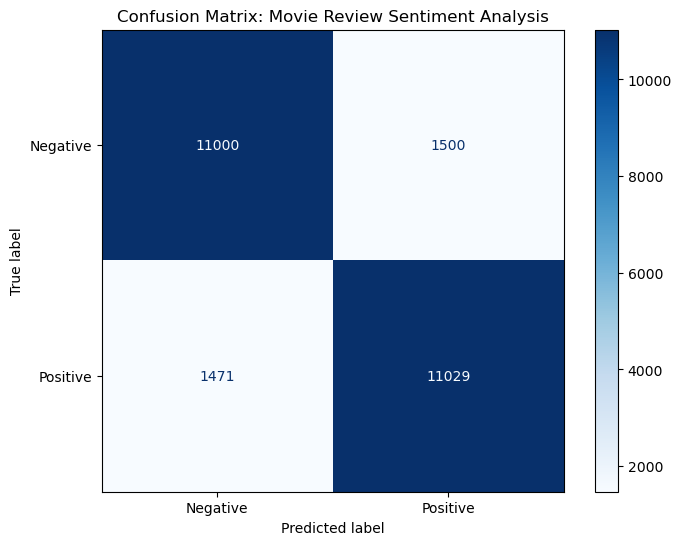

In [89]:
from sklearn.metrics import  ConfusionMatrixDisplay

# Training the final model using the Linear Kernel
print("Training the final model for detailed evaluation...")

final_model = SVC(kernel='linear', cache_size=1000)
final_model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = final_model.predict(X_test)

# Displaying the Classification Report (Precision, Recall, F1-Score)
print("\n--- Project Performance Metrics ---")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

# Plotting the Confusion Matrix
# This provides a visual representation of true positives vs. false positives
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix: Movie Review Sentiment Analysis')
plt.show()

## Saving the Model and Vectorizer
We use joblib to save both the SVM model and the TF-IDF vectorizer. we must save both because the model only understands the specific numerical format the vectorizer creates.

In [93]:
import joblib

# Save the updated versions
joblib.dump(final_model, 'svm_sentiment_model.joblib')
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')

print("Modified model saved Successfully! ")

Modified model saved Successfully! 
